In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

In [2]:
#Systemic lupus erythematosus (SLE)
raw = sc.read_h5ad("GSE174188/GSE174188_CLUES1_adjusted.h5ad")
raw

AnnData object with n_obs × n_vars = 1263676 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
SLE = raw[raw.obs.Status != "Healthy", :]

del raw
SLE

View of AnnData object with n_obs × n_vars = 777258 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# 將細胞數量過少的移除
### 總細胞數 < 0.5% remove
### 總cell type數 < 0.5% remove

In [45]:
rows_to_remove = []
sample = list(set(SLE.obs.ind_cov))
for i in sample:
    if SLE[SLE.obs.ind_cov == i,:].n_obs < SLE.n_obs*0.005:
        rows_to_remove.append(i)
        
SLE_filter = SLE[~SLE.obs.ind_cov.isin(rows_to_remove),:]    

del SLE
SLE_filter

NameError: name 'SLE' is not defined

In [5]:
# 原本 162人 remove < 0.05% after filter 94人
sample_filter = list(set(SLE_filter.obs.ind_cov))
len(sample_filter)

94

# Adjust cell type name

In [15]:
# 新建欄位把cell type做我要的分類
def classify_cell_type(value):
    if value == "pDC" or value == "cDC":
        return "DC"
    elif value == "cM" or value == "ncM":
        return "Monocyte"
    elif value == "T4":
        return "CD4 T"
    elif value == "T8":
        return "CD8 T"
    else:
        return value
    
SLE_filter.obs["cell_type"] = SLE_filter.obs["cg_cov"].apply(classify_cell_type)

C:\Users\benson\AppData\Local\Temp\ipykernel_236760\1899169293.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  SLE_filter.obs["cell_type"] = SLE_filter.obs["cg_cov"].apply(classify_cell_type)


# 開始處理cell dispersion
### 我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [89]:
personal = {}
for i in sample_filter:
    if i not in personal:
        personal[i] = SLE_filter[SLE_filter.obs.ind_cov == i, :]
len(personal)

93

In [90]:
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

age

['20.0',
 '21.0',
 '21.0',
 '21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '28.0',
 '28.0',
 '29.0',
 '29.0',
 '29.0',
 '30.0',
 '31.0',
 '31.0',
 '31.0',
 '31.0',
 '32.0',
 '32.0',
 '33.0',
 '33.0',
 '34.0',
 '35.0',
 '35.0',
 '35.0',
 '36.0',
 '36.0',
 '37.0',
 '37.0',
 '37.0',
 '38.0',
 '38.0',
 '39.0',
 '39.0',
 '40.0',
 '40.0',
 '41.0',
 '41.0',
 '41.0',
 '42.0',
 '43.0',
 '43.0',
 '45.0',
 '45.0',
 '45.0',
 '46.0',
 '46.0',
 '48.0',
 '48.0',
 '49.0',
 '49.0',
 '50.0',
 '51.0',
 '51.0',
 '51.0',
 '52.0',
 '53.0',
 '54.0',
 '55.0',
 '55.0',
 '55.0',
 '55.0',
 '56.0',
 '57.0',
 '57.0',
 '58.0',
 '58.0',
 '58.0',
 '58.0',
 '59.0',
 '59.0',
 '60.0',
 '61.0',
 '64.0',
 '64.0',
 '64.0',
 '65.0',
 '66.0',
 '66.0',
 '66.0',
 '68.0',
 '70.0',
 '71.0',
 '71.0',
 '83.0']

# remove 1811_1811 因為B, plasma blast都是0

In [88]:
del personal['1811_1811'],sorted_personal['1811_1811']
sample_filter.remove("1811_1811")

# Cell Dispersion Calculate

In [21]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)
    
    # 紀錄50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)
    
    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較 
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]
    
    # matric 會是aaabbbccc
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    # matirc 會是abcabcabc
    index2 = np.tile(np.arange(0, ncells, 1), ncells)
    
    X = data[:, index1]
    Y = data[:, index2]
    
    # Euclidean Distance 
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))
    
    distance_matrix = np.reshape(out, (ncells, ncells))
    
    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    # np.count_nonzero 計算非0的部分有多少個
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態
    
    # 挑出最小值
    minimum = 50
    for i in sorted_personal:
        a = sorted_personal[i][sorted_personal[i].obs.cell_type == cell_type_name, :].obs
        if len(a) < minimum:
            minimum = len(a)

    pbar = tqdm(total = len(sorted_personal))

    dispersion_personal = []
    mean = []
    distance = []
    # 總共人數
    for i in sorted_personal:
        dispersion = []
        # 取得所需的cell type
        celltype = sorted_personal[i][sorted_personal[i].obs.cell_type == cell_type_name, :]
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(celltype, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))
        
       
        distance.append(distance_matrix)
        
        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))
        
        pbar.update()
    
    pbar.close()
    
    # 計算標準差
    count = 0
    std = [] # 每一個人的標準差
    for i in range(len(distance)):
        count = (distance[i]-mean[i]) * (distance[i]-mean[i])
        std.append(np.sqrt(np.sum(count)/(len(distance)*((len(distance[i])*(len(distance[i])-1))/2)-1)))
    
    
    return dispersion_personal, mean, std

# 結果畫圖

In [114]:
def scatter_plot(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    
    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)  
    
    plt.xlabel('Age')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(age, fontsize = 6, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    #plt.savefig(f'Result_picture/GSE174188/Cell dispersion/Scatter_plot_{cell_type}.png', dpi=900)

    
    
    # 顯示圖表
    plt.show()
    

def errorbar(mean, std, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = mean[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std[i], color = cmap(i), fmt = 'o')

    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)
        
    # 計算趨勢線的參數
    z = np.polyfit([int(float(a)) for a in age], mean, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    print("斜率 :",p)
    test = list(set([int(float(a)) for a in age]))
    # 在圖中添加趨勢線
    plt.plot(test, p(test), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Dispersion')

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/Cell dispersion/SLE/Cell Dispersion_{cell_type}_SLE.png', dpi=900, bbox_inches='tight')

    # 顯示圖表
    plt.show()
    
def distribution(mean, std, age, cell_type):
    for i in range(0, len(mean)):
        x = np.arange(-4, 10, 0.001)
        y = norm.pdf(x, mean[i], std[i])
        plt.plot(x,y)
    
    # 添加圖例
    plt.legend(age, fontsize = 8, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    # 添加標題和軸標籤
    plt.title(f"{cell_type} cell dispersion")
    plt.xlabel('Different Sample')
    plt.ylabel('Probability Density')


    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/Cell dispersion/SLE/{cell_type} cell dispersion_SLE.png', dpi=900, bbox_inches='tight')

# NK cell dispersion

In [91]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")


100%|██████████| 93/93 [01:01<00:00,  1.51it/s]


斜率 :  
-0.00931 x + 1.877


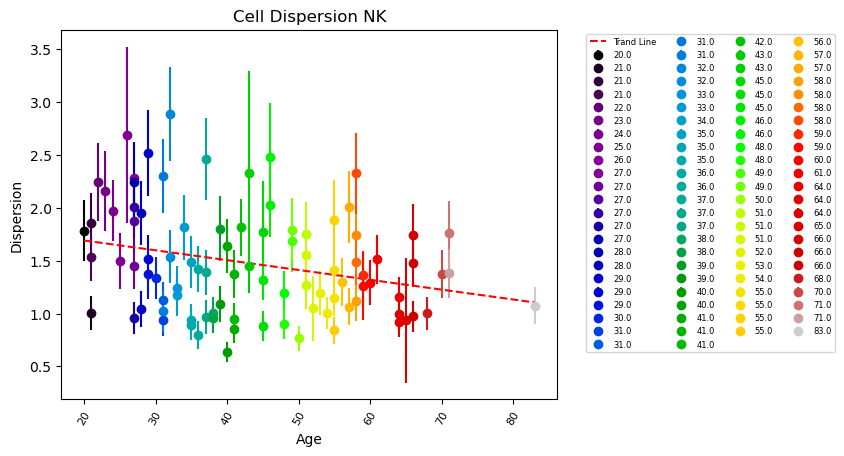

In [113]:
errorbar(mean_NK, std_NK, "Cell Dispersion NK", "NK")

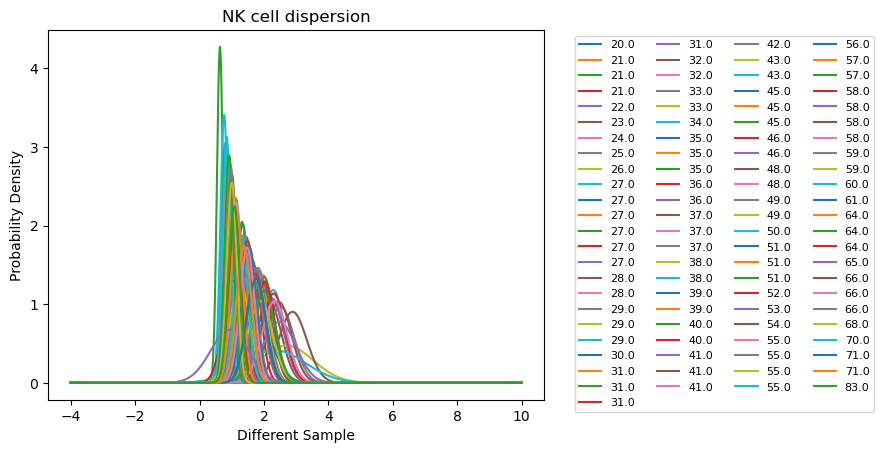

In [115]:
distribution(mean_NK, std_NK, age, "NK")

# Monocyte cell dispersion

In [94]:
dispersion_personal_Monocyte, mean_Monocyte, std_Monocyte = Excute_all(sorted_personal, "Monocyte")


100%|██████████| 93/93 [05:04<00:00,  3.27s/it]


斜率 :  
-0.006447 x + 5.258


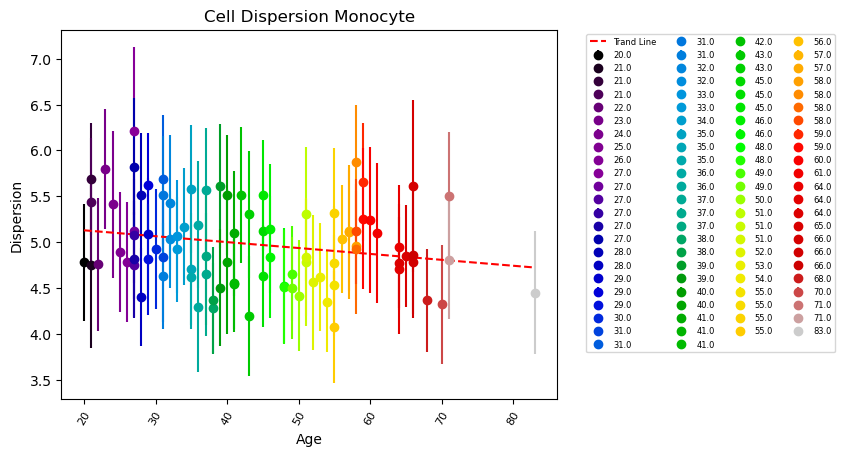

In [116]:
errorbar(mean_Monocyte, std_Monocyte, "Cell Dispersion Monocyte", "Monocyte")

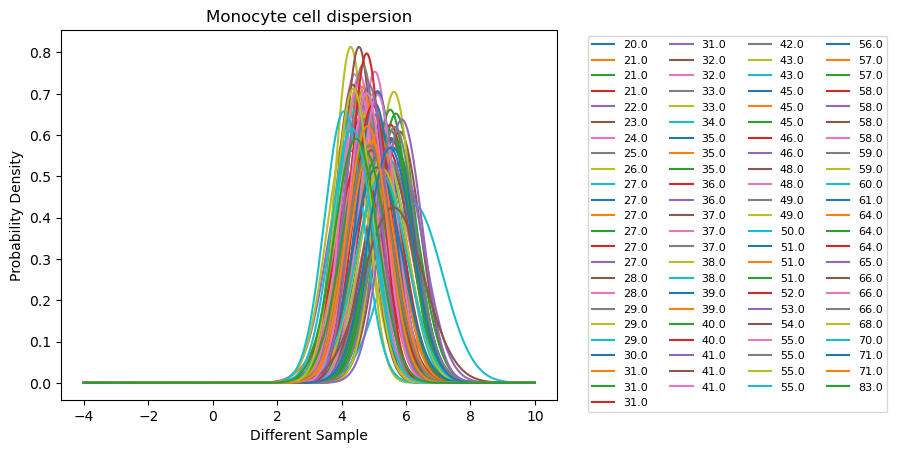

In [117]:
distribution(mean_Monocyte, std_Monocyte, age, "Monocyte")

# CD4 T cell dispersion

In [97]:
dispersion_personal_CD4T, mean_CD4T, std_CD4T = Excute_all(sorted_personal, "CD4 T")

100%|██████████| 93/93 [04:09<00:00,  2.68s/it]


斜率 :  
-0.001457 x + 3.446


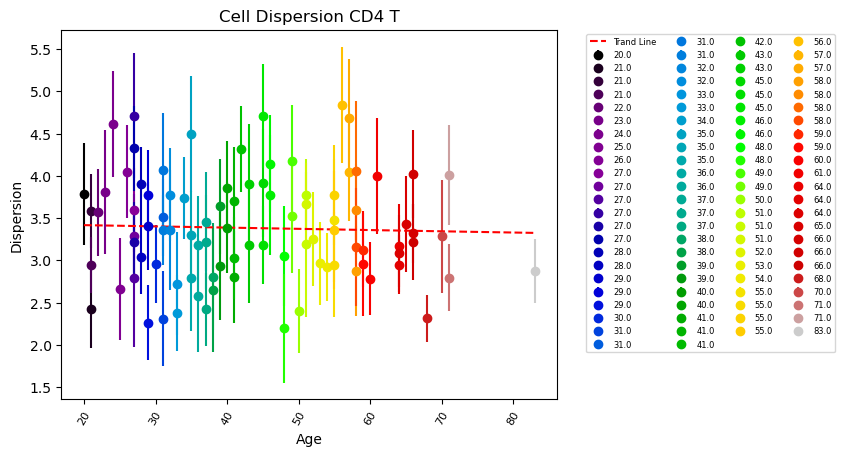

In [118]:
errorbar(mean_CD4T, std_CD4T, "Cell Dispersion CD4 T", "CD4 T")

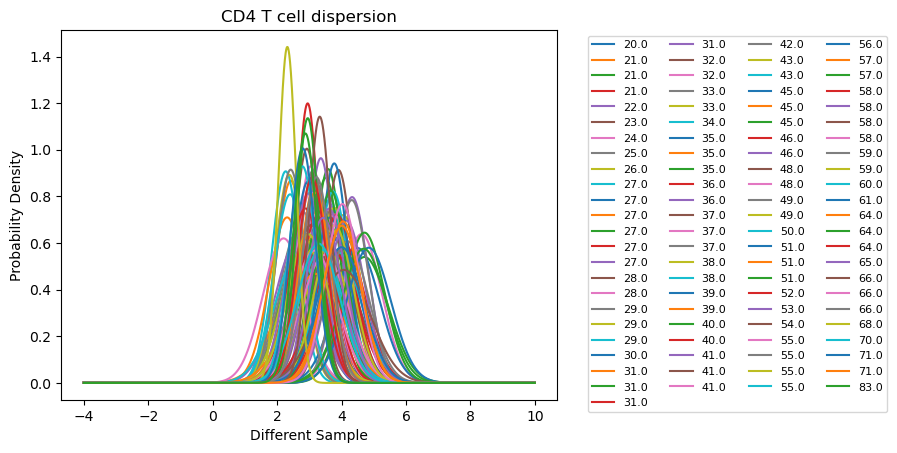

In [119]:
distribution(mean_CD4T, std_CD4T, age, "CD4 T")

# CD8 T cell dispersion

In [100]:
dispersion_personal_CD8T, mean_CD8T, std_CD8T = Excute_all(sorted_personal, "CD8 T")

100%|██████████| 93/93 [03:25<00:00,  2.21s/it]


斜率 :  
0.007451 x + 3.265


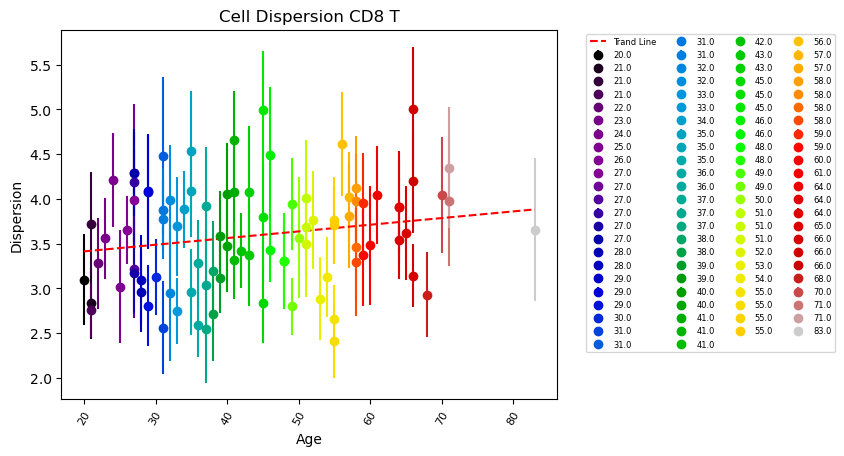

In [120]:
errorbar(mean_CD8T, std_CD8T, "Cell Dispersion CD8 T", "CD8 T")

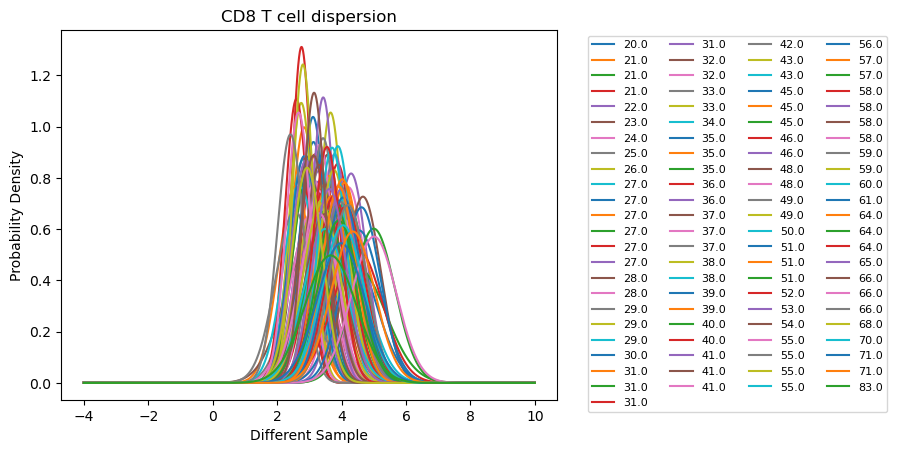

In [121]:
distribution(mean_CD8T, std_CD8T, age, "CD8 T")

# B cell dispersion

In [103]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 93/93 [01:40<00:00,  1.08s/it]


斜率 :  
-0.003461 x + 1.265


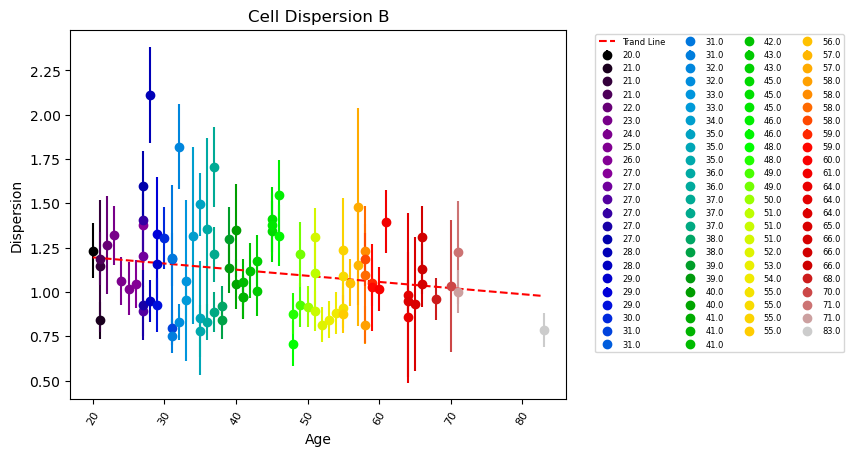

In [122]:
errorbar(mean_B, std_B, "Cell Dispersion B", "B")

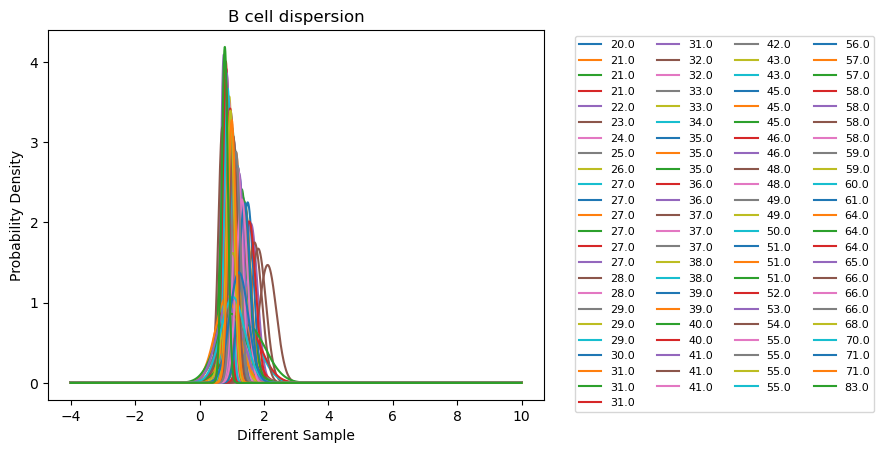

In [123]:
distribution(mean_B, std_B, age, "B")

# DC cell dispersion

In [106]:
dispersion_personal_DC, mean_DC, std_DC = Excute_all(sorted_personal, "DC")

100%|██████████| 93/93 [00:29<00:00,  3.16it/s]


斜率 :  
-0.002347 x + 1.44


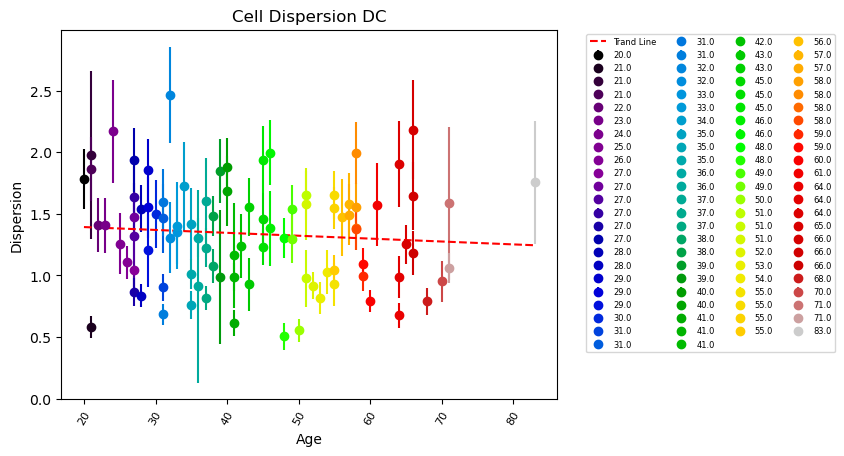

In [124]:
errorbar(mean_DC, std_DC, "Cell Dispersion DC", "DC")

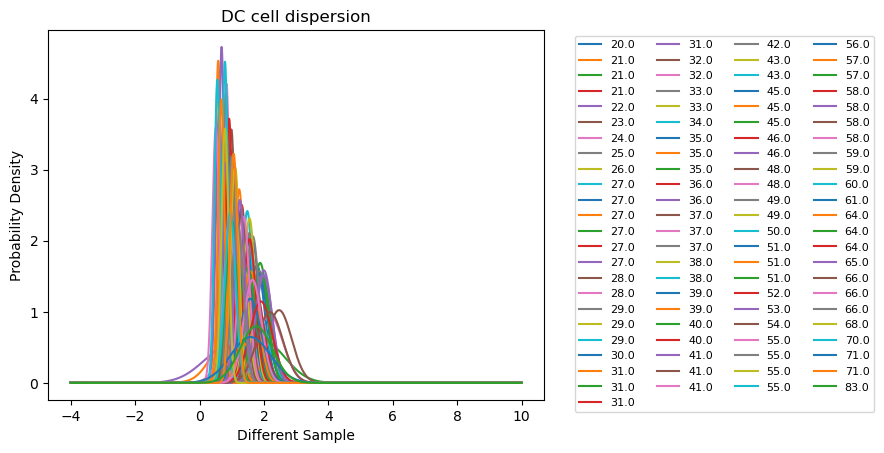

In [125]:
distribution(mean_DC, std_DC, age, "DC")

# Mean & Std寫檔

In [109]:
import csv
with open('mean_and_stdev_GSE174188_SLE.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_CD4T', 'mean_CD8T', 'mean_B', 'mean_Monocyte', 'mean_DC', 'std_NK', 'std_CD4T', 'std_CD8T', 'std_B', 'std_Monocyte', 'std_DC'])    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC in zip(sorted_personal, age, mean_NK, mean_CD4T, mean_CD8T, mean_B, mean_Monocyte, mean_DC, std_NK, std_CD4T, std_CD8T, std_B, std_Monocyte, std_DC):
        writer.writerow([sample] + [Age, Mean_NK, Mean_CD4T, Mean_CD8T, Mean_B, Mean_Monocyte, Mean_DC, Std_NK, Std_CD4T, Std_CD8T, Std_B, Std_Monocyte, Std_DC])